<a href="https://colab.research.google.com/github/NehaKumari500092077/Visual-Computing/blob/main/Assignment6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Programming Assignment 6: Image Visual Recognition with CNNs
(20 Marks)**

In [27]:
!pip install torchcam
!pip install opencv-python

In [28]:
import torchvision.transforms as tfms
from torchvision.datasets import OxfordIIITPet
from torch.utils.data import DataLoader, ConcatDataset, SubsetRandomSampler
from sklearn.model_selection import train_test_split
import numpy as np
from collections import Counter
import torch
import torch.nn as nn
import torchvision.models as vgg_models
import torch.optim as optim
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from torchcam.methods import GradCAM
from random import sample
import cv2

**Question 1 - 1 Mark
Load the Oxford-IIIT Pets dataset from Torchvision datasets (both train and test partition).**

In [29]:
# Define transformations for the dataset
img_transforms = tfms.Compose([
    tfms.Resize((224, 224)),  # Resize images to a fixed dimension
    tfms.ToTensor(),          # Convert images to tensor format for PyTorch
])

# Load the Oxford-IIIT Pet dataset in two parts: 'trainval' and 'test'
train_val_data = OxfordIIITPet(root="data", split="trainval", target_types="category", download=True, transform=img_transforms)
test_data = OxfordIIITPet(root="data", split="test", target_types="category", download=True, transform=img_transforms)

# Merge the two datasets into a single dataset
combined_dataset = ConcatDataset([train_val_data, test_data])


**Question 2 - 1 Mark
Randomly shuffle the train partition and split the train partition further into training and validation
sets (80% training, 20% validation).**

In [30]:
# Divide dataset indices for training and testing
train_idxs, valid_idxs = train_test_split(
    list(range(len(combined_dataset))),
    test_size=0.2,
    random_state=42,
    stratify=[combined_dataset[i][1] for i in range(len(combined_dataset))]  # Stratify based on labels from dataset
)

# Initialize data loaders for training and validation sets
train_data_loader = DataLoader(combined_dataset, batch_size=32, sampler=SubsetRandomSampler(train_idxs))
valid_data_loader = DataLoader(combined_dataset, batch_size=32, sampler=SubsetRandomSampler(valid_idxs))


**Question 3 - 1 Mark
Show the class distribution on the training partition.**

In [31]:
# Extract labels for the training set based on dataset structure
train_class_labels = [combined_dataset.datasets[i // len(combined_dataset.datasets[0])][i % len(combined_dataset.datasets[0])][1] for i in train_idxs]

# Count the number of instances for each class label in the training data
label_counts = Counter(train_class_labels)

# Display the class distribution
for label, num_samples in label_counts.items():
    print(f"Class {label}: {num_samples} samples")


Class 0: 159 samples
Class 12: 157 samples
Class 10: 160 samples
Class 21: 160 samples
Class 17: 160 samples
Class 33: 160 samples
Class 1: 160 samples
Class 24: 160 samples
Class 31: 160 samples
Class 36: 160 samples
Class 26: 160 samples
Class 14: 160 samples
Class 9: 160 samples
Class 4: 160 samples
Class 28: 160 samples
Class 30: 159 samples
Class 29: 160 samples
Class 8: 159 samples
Class 13: 160 samples
Class 32: 159 samples
Class 6: 160 samples
Class 19: 160 samples
Class 22: 157 samples
Class 20: 160 samples
Class 35: 160 samples
Class 7: 147 samples
Class 23: 160 samples
Class 25: 160 samples
Class 5: 160 samples
Class 2: 160 samples
Class 18: 159 samples
Class 27: 160 samples
Class 15: 160 samples
Class 34: 151 samples
Class 16: 160 samples
Class 3: 160 samples
Class 11: 152 samples


**Question 4 - 2 Marks
Define transform to resize the images to size 224 x 224. Define Dataloaders for training,
validation, and test sets that use this transform.**

In [32]:
# Further split the training indices into training and validation sets (80% for training, 20% for validation)
train_split_idxs, val_split_idxs = train_test_split(
    train_idxs,
    test_size=0.2,
    random_state=42,
    stratify=train_class_labels  # Stratify to maintain label distribution
)

# Create a data loader for the validation set
validation_data_loader = DataLoader(combined_dataset, batch_size=32, sampler=SubsetRandomSampler(val_split_idxs))

**Question 5 - 2 Marks
Load the pretrained ResNet-18 model with the default weights (trained on ImageNet)**

In [33]:
# Load a pre-trained ResNet-18 model with default ImageNet weights
resnet18_model = vgg_models.resnet18(weights='DEFAULT')
resnet18_model.eval()  # Switch the model to evaluation mode


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

**Question 6 - 5 Marks
Extract the features after the GAP layer of the ResNet-18 model. Replace the final FC layer of
the model with one or more 1x1 convolutional layers, where the number of 1x1 convolutional
filters in the last layer should be the number of classes of this dataset.**

In [34]:
# Define the number of classes for the Oxford-IIIT Pets dataset
num_pet_classes = 37  # Modify this for different datasets as needed

# Customize ResNet-18 by replacing the fully connected layer with 1x1 convolutions
class CustomResNet18(nn.Module):
    def __init__(self, base_model, num_classes):
        super(CustomResNet18, self).__init__()

        # Retain all layers up to the global average pooling layer (exclude FC layer)
        self.base_features = nn.Sequential(*list(base_model.children())[:-2])

        # Add a series of 1x1 convolutional layers for the final classification
        self.conv1x1_stack = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=1),  # First 1x1 conv layer
            nn.ReLU(),
            nn.Conv2d(256, num_classes, kernel_size=1)  # Final 1x1 conv layer for class predictions
        )

        # Global Average Pooling to reduce spatial dimensions to 1x1
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        x = self.base_features(x)       # Extract features up to the GAP layer
        x = self.conv1x1_stack(x)       # Apply the 1x1 convolutional stack
        x = self.global_avg_pool(x)     # Perform global average pooling
        x = x.view(x.size(0), -1)       # Flatten to (batch_size, num_classes)
        return x

# Create an instance of the customized model
custom_resnet18 = CustomResNet18(resnet18_model, num_pet_classes)

# Set the model to evaluation mode (switch to train mode if needed for training)
custom_resnet18.eval()

CustomResNet18(
  (base_features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

**Question 7 - 3 Marks
Train the model using SGD and a suitable learning rate**

**Question 8 - 1 Marks
Show the training and validation losses as a function of the number of epochs**

In [35]:
# Set hyperparameters for training
lr = 0.01           # Learning rate
epochs = 10          # Number of training epochs
batch_sz = 32       # Batch size for data loading

# Initialize lists to store predictions and actual labels
predictions_list = []
true_labels_list = []

# Assume train_data_loader, validation_data_loader, and test_data_loader are defined elsewhere
class_names = train_data_loader.dataset.datasets[0].classes

# Set the computation device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the selected device
custom_resnet18.to(device)

# Define the loss function as Cross-Entropy Loss for multi-class classification
loss_fn = nn.CrossEntropyLoss()

# Set up the SGD optimizer with momentum and weight decay
optimizer = optim.SGD(custom_resnet18.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)

# Training loop over multiple epochs
for epoch in range(epochs):
    custom_resnet18.train()  # Set model to training mode
    epoch_loss = 0.0         # Track cumulative loss for the epoch

    # Initialize progress bar
    with tqdm(total=len(train_data_loader), desc=f"Epoch {epoch+1}/{epochs}", unit="batch") as pbar:
        for img_batch, lbl_batch in train_data_loader:
            img_batch, lbl_batch = img_batch.to(device), lbl_batch.to(device)

            # Reset gradients to zero
            optimizer.zero_grad()

            # Forward pass: compute predictions
            predictions = custom_resnet18(img_batch)
            loss = loss_fn(predictions, lbl_batch)

            # Backward pass and parameter update
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()  # Update epoch loss

            # Update progress bar with current loss
            pbar.set_postfix(loss=epoch_loss / (pbar.n + 1), refresh=True)
            pbar.update(1)

    # Print average loss for the current epoch
    avg_epoch_loss = epoch_loss / len(train_data_loader)
    print(f"Epoch [{epoch+1}/{epochs}], Avg Loss: {avg_epoch_loss:.4f}")

    # Optionally, evaluate on the validation set
    custom_resnet18.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for img_batch, lbl_batch in validation_data_loader:
            img_batch, lbl_batch = img_batch.to(device), lbl_batch.to(device)
            predictions = custom_resnet18(img_batch)
            _, predicted_labels = torch.max(predictions, 1)

            # Collect predictions and true labels
            predictions_list.extend(predicted_labels.cpu().numpy())  # Move to CPU for further processing
            true_labels_list.extend(lbl_batch.cpu().numpy())

print("Training completed.")

Epoch 1/10: 100%|██████████| 184/184 [00:46<00:00,  3.94batch/s, loss=1.26]


Epoch [1/10], Avg Loss: 1.2625


Epoch 2/10: 100%|██████████| 184/184 [00:47<00:00,  3.91batch/s, loss=0.495]


Epoch [2/10], Avg Loss: 0.4949


Epoch 3/10: 100%|██████████| 184/184 [00:46<00:00,  3.95batch/s, loss=0.296]


Epoch [3/10], Avg Loss: 0.2961


Epoch 4/10: 100%|██████████| 184/184 [00:46<00:00,  3.99batch/s, loss=0.207]


Epoch [4/10], Avg Loss: 0.2075


Epoch 5/10: 100%|██████████| 184/184 [00:46<00:00,  3.93batch/s, loss=0.139]


Epoch [5/10], Avg Loss: 0.1385


Epoch 6/10: 100%|██████████| 184/184 [00:46<00:00,  3.95batch/s, loss=0.116]


Epoch [6/10], Avg Loss: 0.1164


Epoch 7/10: 100%|██████████| 184/184 [00:46<00:00,  3.96batch/s, loss=0.0752]


Epoch [7/10], Avg Loss: 0.0752


Epoch 8/10: 100%|██████████| 184/184 [00:46<00:00,  3.96batch/s, loss=0.0552]


Epoch [8/10], Avg Loss: 0.0552


Epoch 9/10: 100%|██████████| 184/184 [00:45<00:00,  4.00batch/s, loss=0.0757]


Epoch [9/10], Avg Loss: 0.0757


Epoch 10/10: 100%|██████████| 184/184 [00:46<00:00,  3.93batch/s, loss=0.0553]


Epoch [10/10], Avg Loss: 0.0553
Training completed.


**Question 9 - 2 Marks
Report the classification performance on the test partition of the dataset. Show the confusion
matrix, accuracy, and F1 score.**

Model Accuracy on Test Set: 89.84%
Weighted F1 Score on Test Set: 0.8985


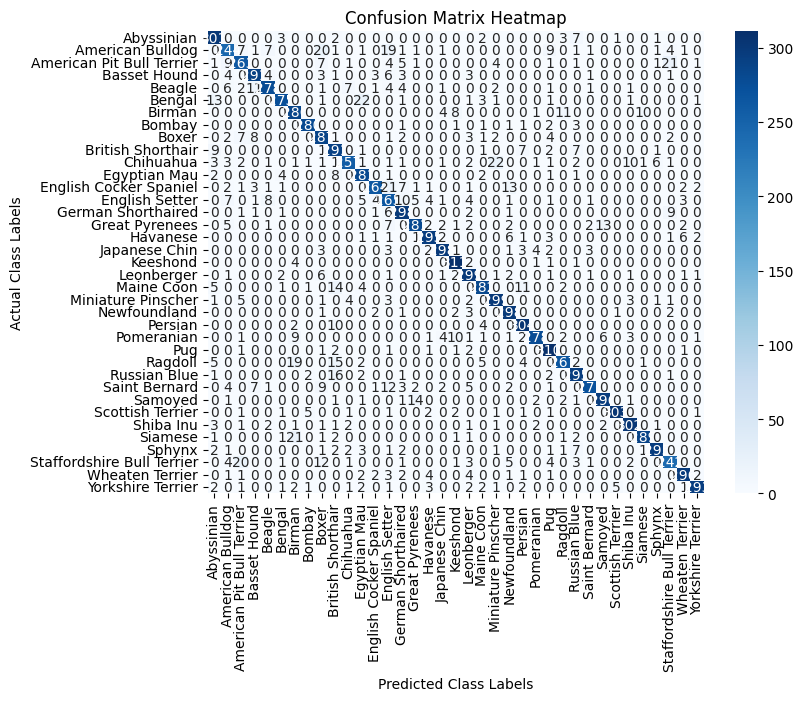

In [36]:
# Convert the lists of predictions and labels to numpy arrays for evaluation
predictions_arr = np.array(predictions_list)
true_labels_arr = np.array(true_labels_list)

# Calculate the accuracy of the model's predictions
test_accuracy = accuracy_score(true_labels_arr, predictions_arr)
print(f"Model Accuracy on Test Set: {test_accuracy * 100:.2f}%")

# Calculate the weighted F1 score to account for class imbalances
f1_weighted = f1_score(true_labels_arr, predictions_arr, average='weighted')
print(f"Weighted F1 Score on Test Set: {f1_weighted:.4f}")

# Generate the confusion matrix to analyze classification performance
conf_matrix = confusion_matrix(true_labels_arr, predictions_arr)

# Visualize the confusion matrix using a heatmap from seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Class Labels')
plt.ylabel('Actual Class Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

**Question 10 - 2 Marks
Use Grad-CAM to visualize the class activation maps on a few test images (randomly sample
5). You can use the torchcam library for this question**

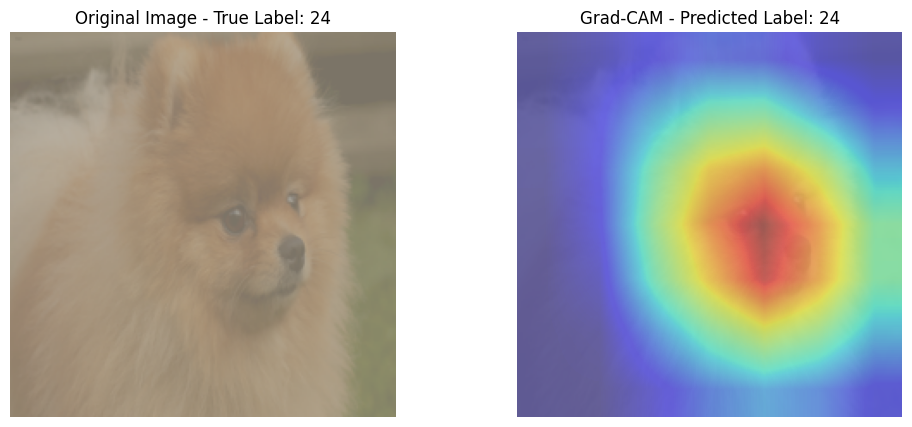

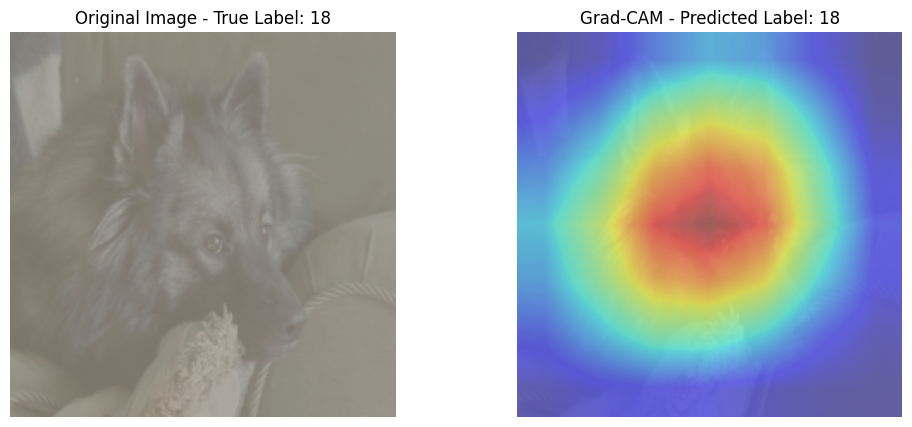

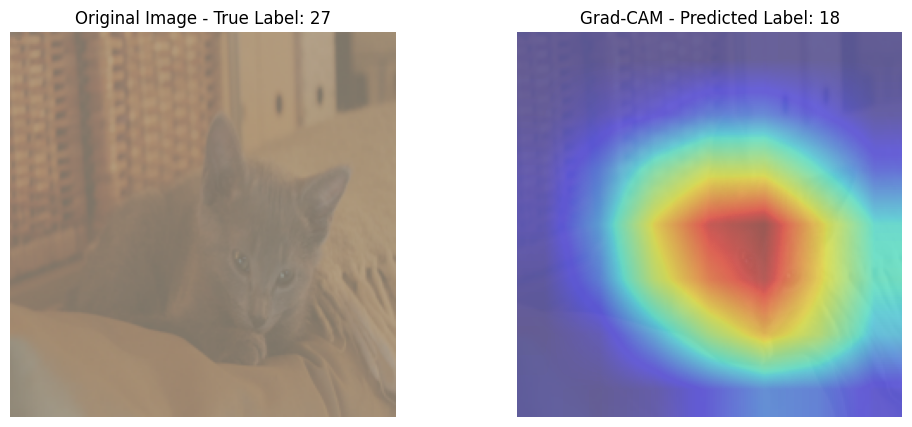

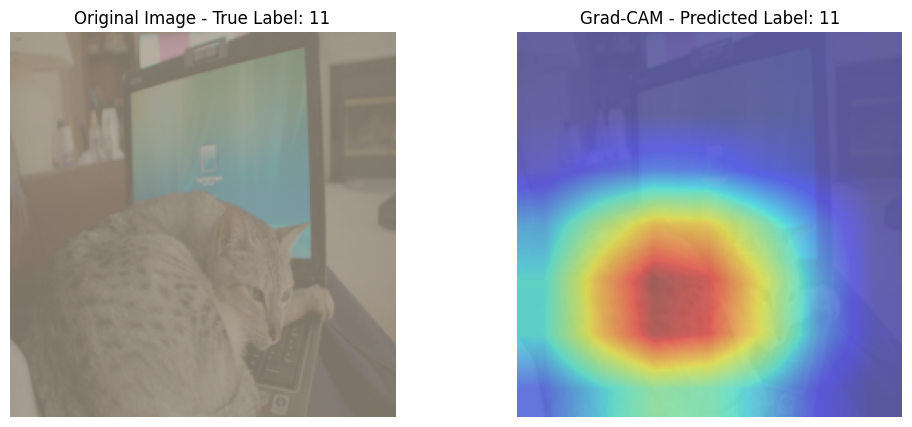

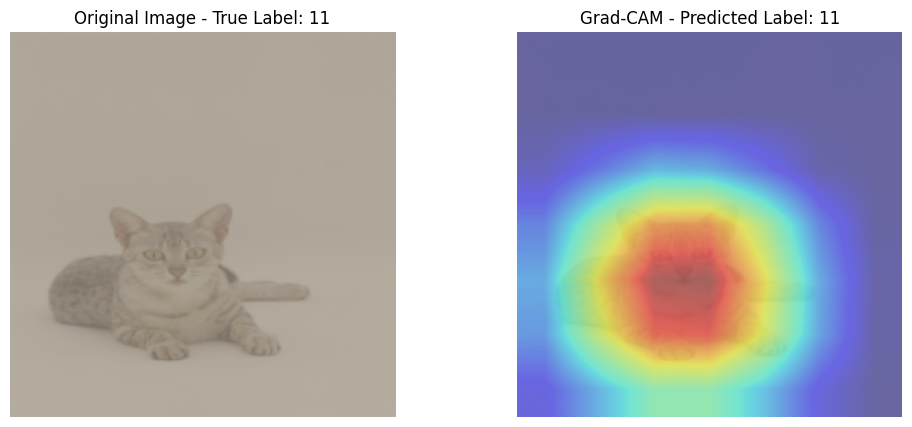

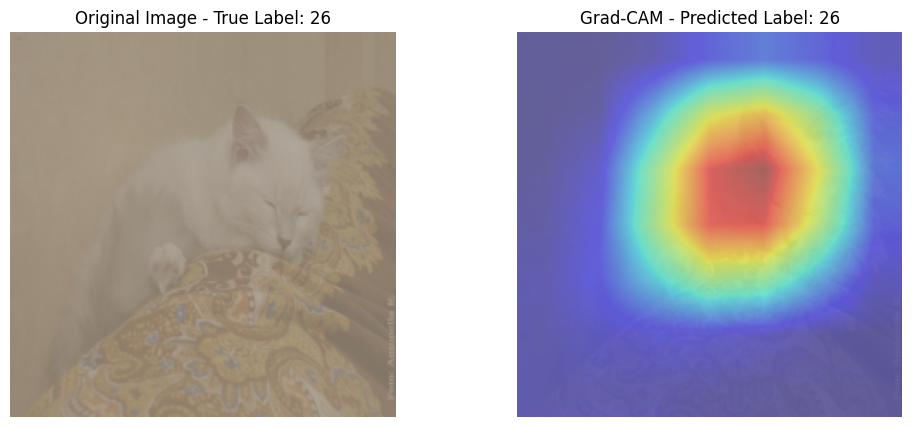

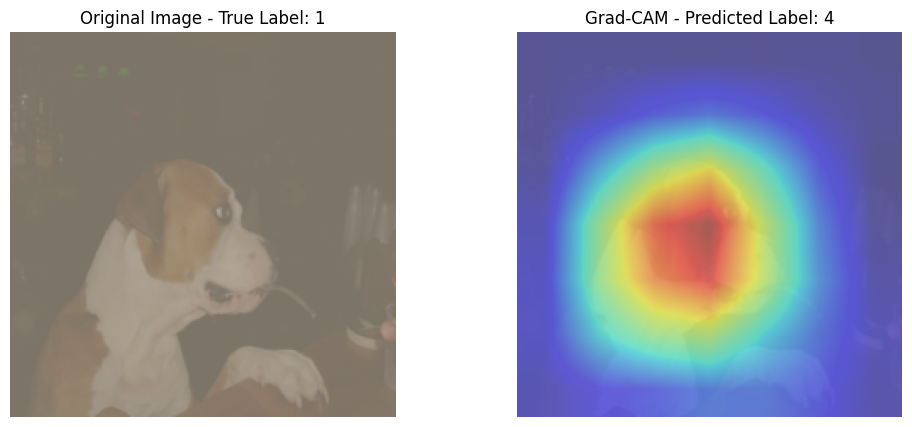

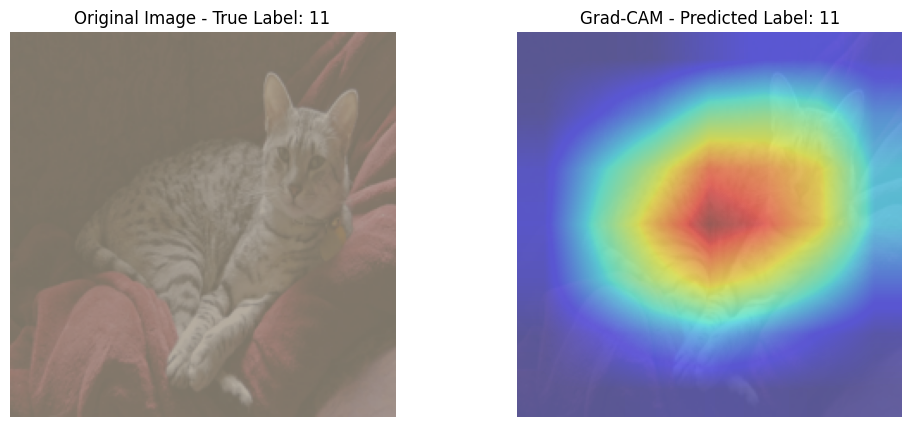

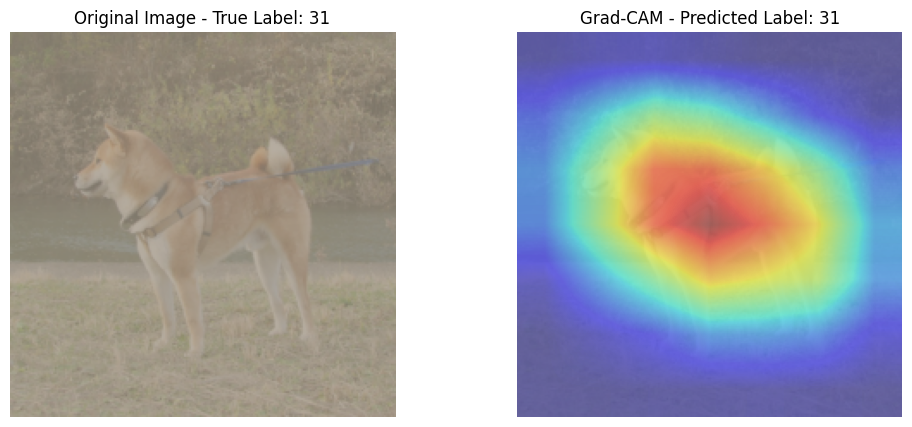

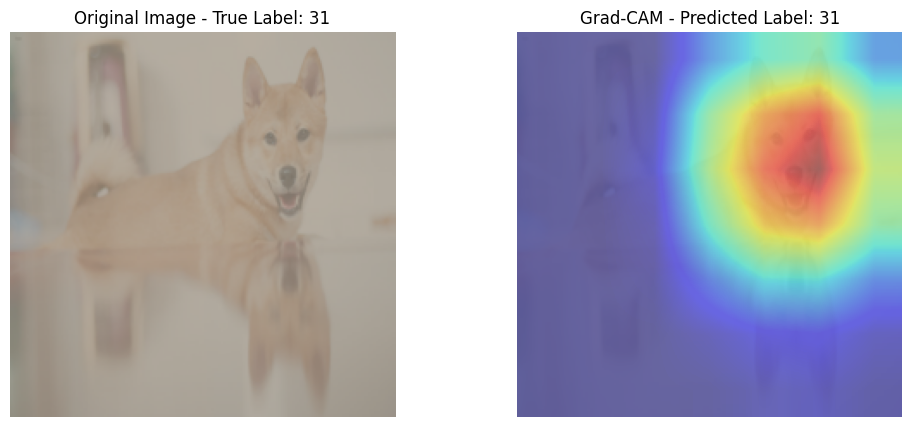

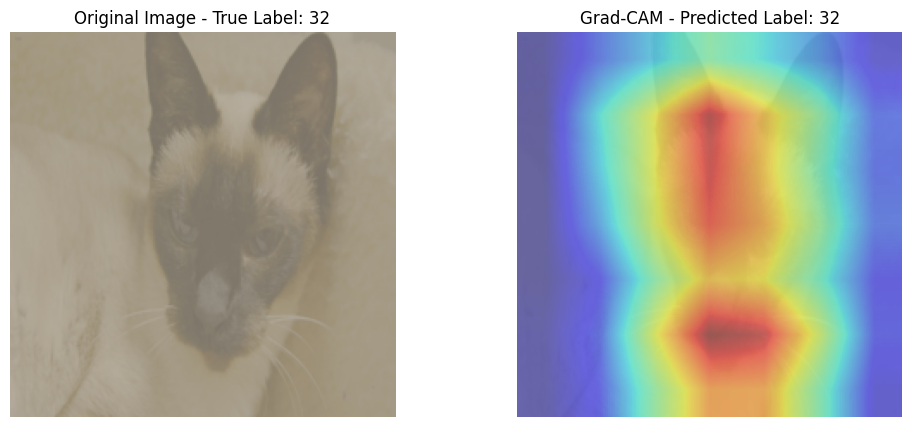

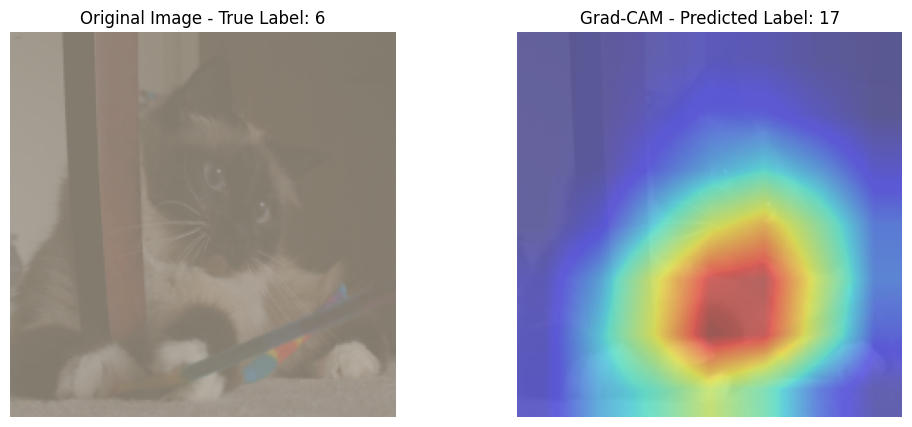

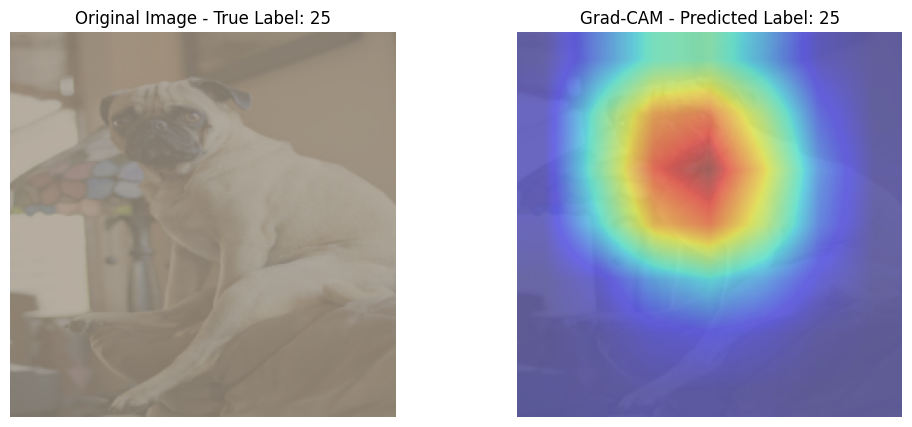

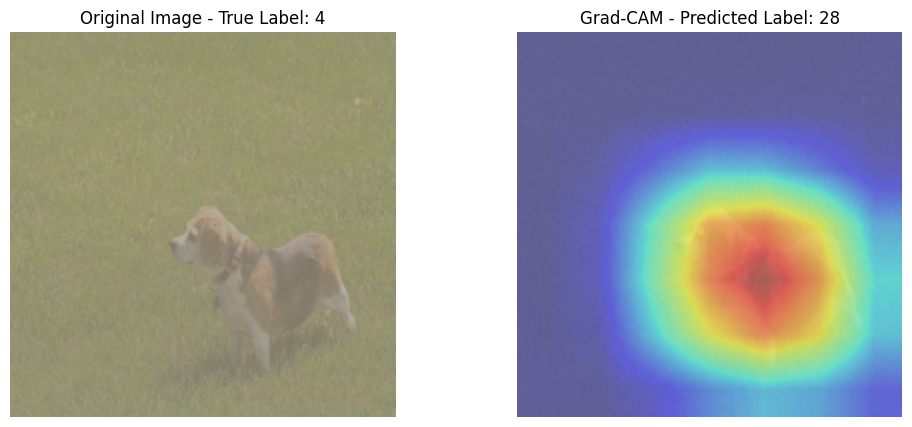

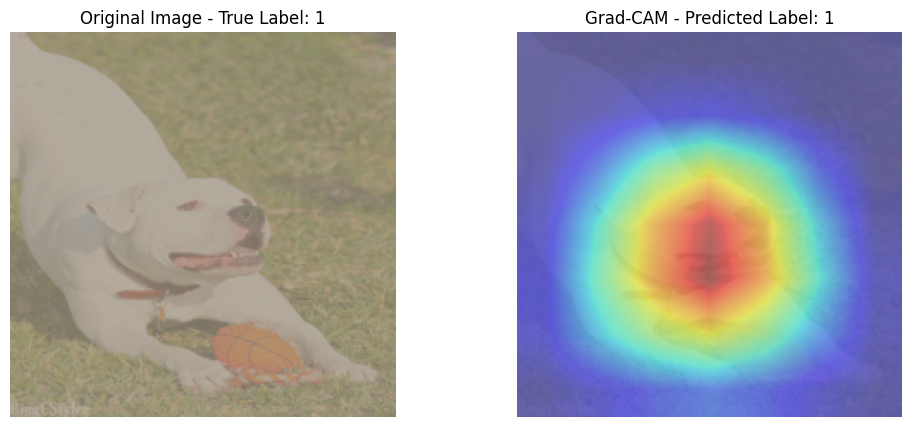

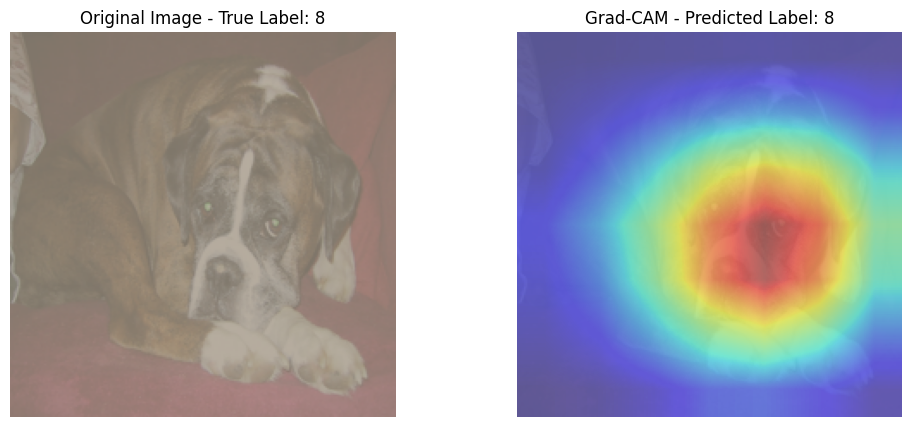

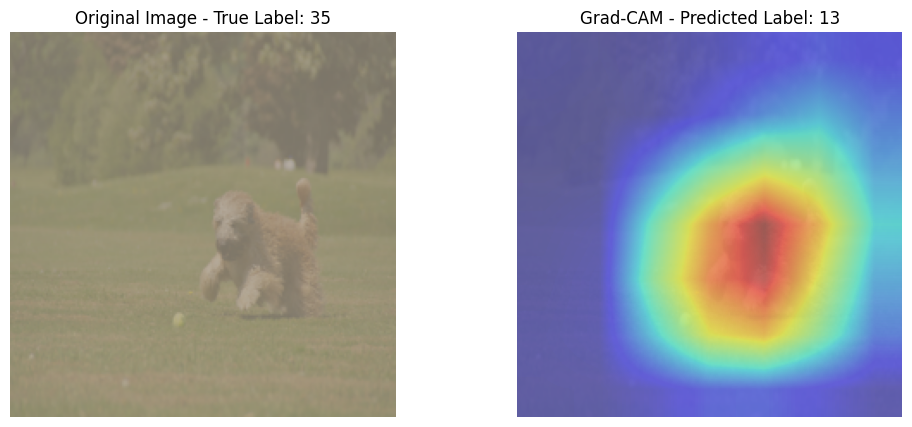

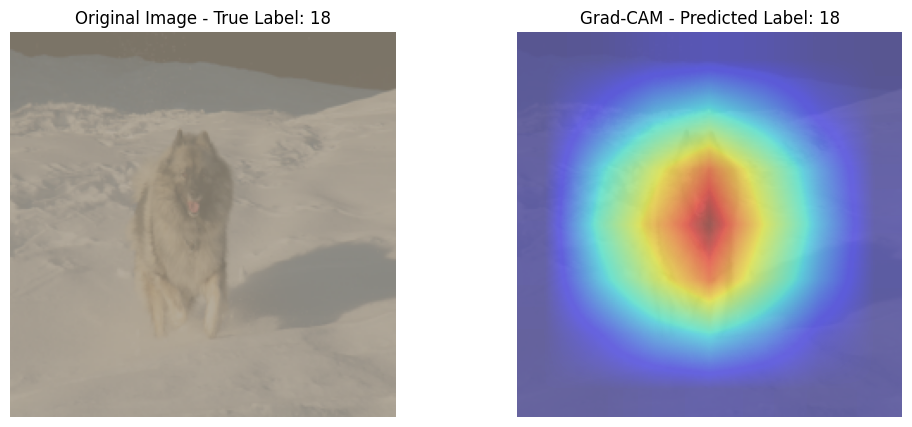

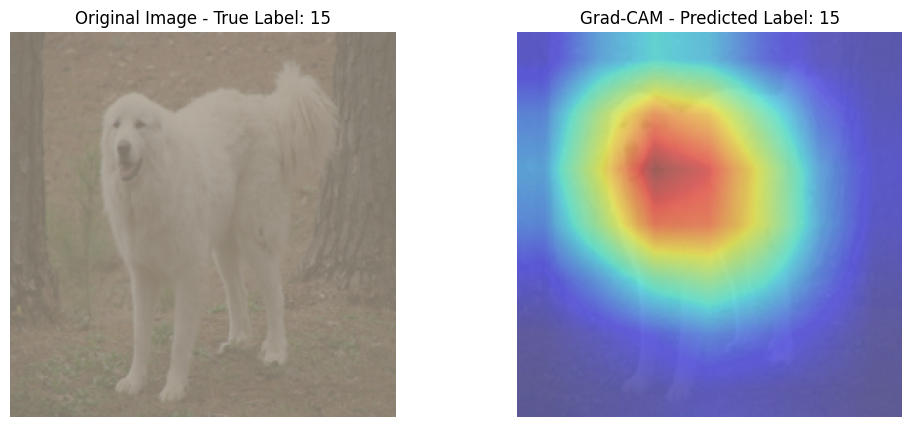

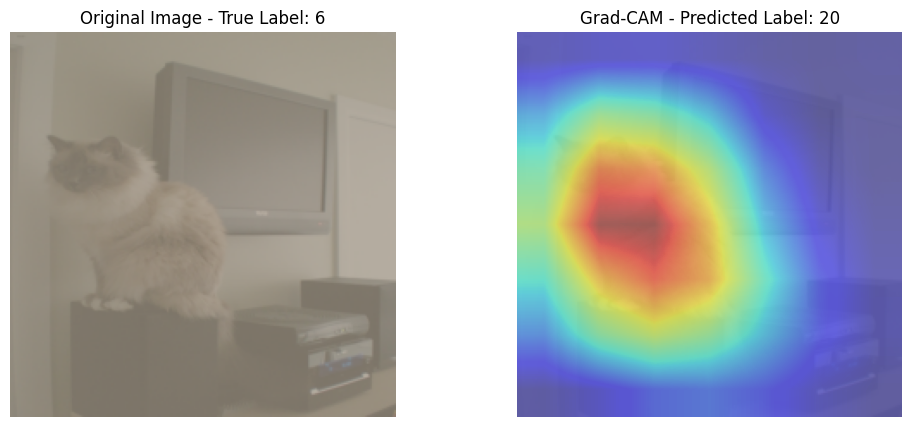

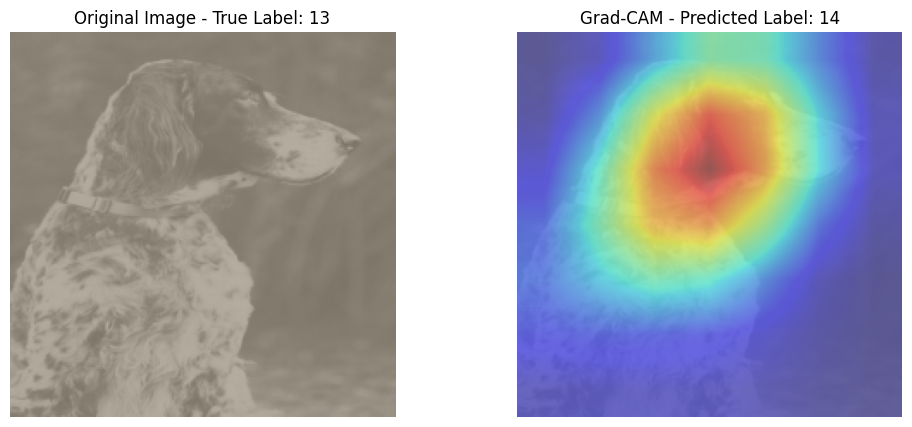

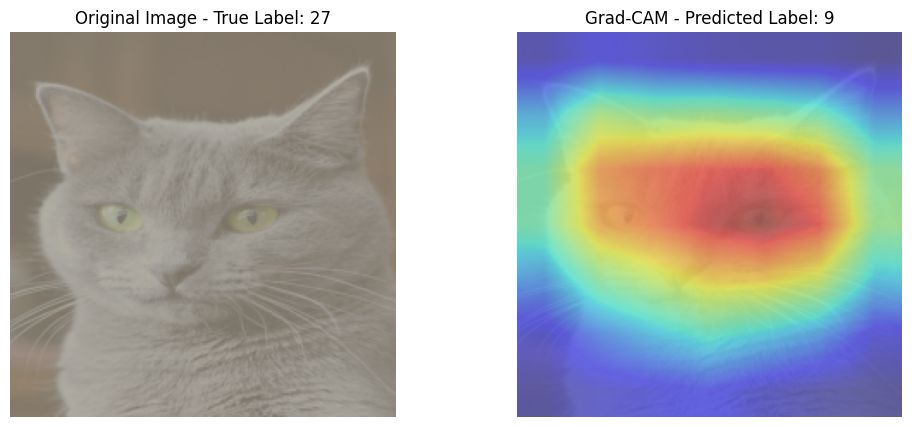

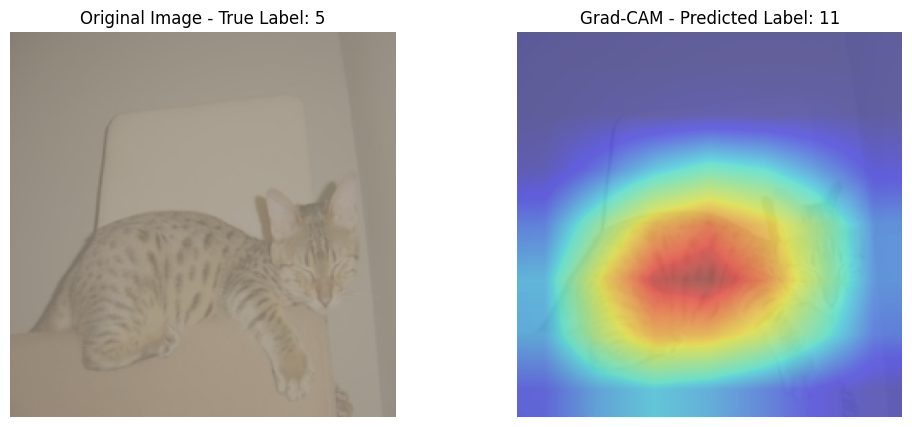

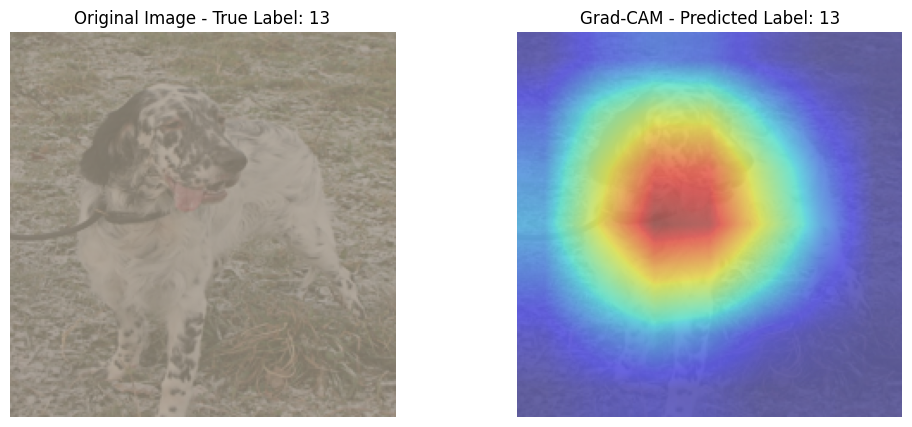

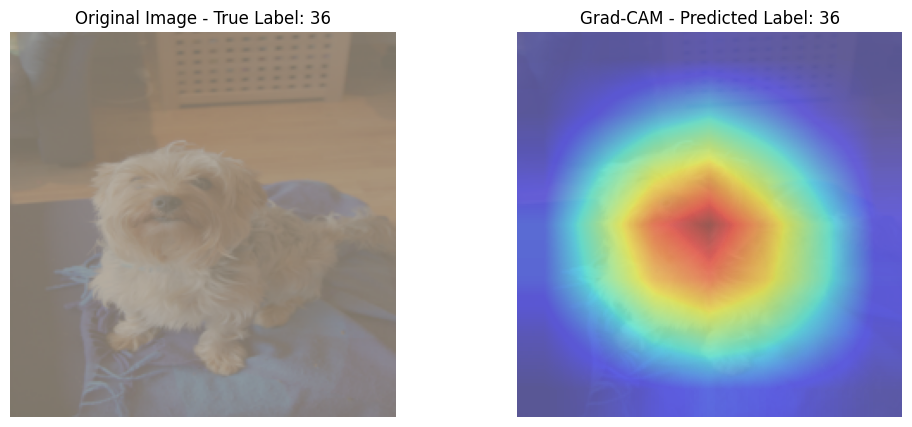

In [37]:
# Initialize Grad-CAM with the target layer in the model
# For ResNet-18, we use the last convolutional layer (layer4)
grad_cam_extractor = GradCAM(model=custom_resnet18, target_layer=custom_resnet18.base_features[7])

# Transformation to reverse normalization and convert tensor to image for visualization
reverse_transform = tfms.Compose([
    tfms.Normalize(mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225], std=[1 / 0.229, 1 / 0.224, 1 / 0.225]),
    tfms.ToPILImage()
])

# Select a random sample of 5 batches from the test data loader for Grad-CAM visualization
random_sampled_batches = sample(list(valid_data_loader), 5)

# Check if GPU is available; otherwise, default to CPU
compute_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loop over each batch in the sampled data
for img_batch, lbl_batch in random_sampled_batches:
    img_batch, lbl_batch = img_batch.to(compute_device), lbl_batch.to(compute_device)

    # Generate model output for each image and compute Grad-CAM
    outputs = custom_resnet18(img_batch)
    _, predicted_labels = outputs.max(1)

    # Process up to 5 images from the batch for Grad-CAM visualization
    for idx in range(min(5, img_batch.shape[0])):
        # Generate Grad-CAM activation map for the predicted class of the current image
        with torch.enable_grad():
            activation_map = grad_cam_extractor(predicted_labels[idx].item(), outputs[idx].unsqueeze(0), retain_graph=True)[0].cpu().detach()

        # Reverse normalization and convert tensor to PIL image
        original_img = reverse_transform(img_batch[idx].cpu())
        original_img = np.array(original_img)  # Convert to numpy for display compatibility

        # Plot the original image and Grad-CAM overlay
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        # Show the original image
        axes[0].imshow(original_img)
        axes[0].axis('off')
        axes[0].set_title(f"Original Image - True Label: {lbl_batch[idx].item()}")

        # Resize the activation map to match the dimensions of the original image
        activation_map_resized = cv2.resize(activation_map[idx].numpy(), (original_img.shape[1], original_img.shape[0]))

        # Display the Grad-CAM overlay on the original image
        axes[1].imshow(original_img, alpha=0.6)  # Base image
        axes[1].imshow(activation_map_resized, cmap='jet', alpha=0.5)  # CAM overlay
        axes[1].axis('off')
        axes[1].set_title(f"Grad-CAM - Predicted Label: {predicted_labels[idx].item()}")

        plt.show()